# Predicting Stock Movement with Random Forest

This Paper can be found here: [Predicting the direction of stock market prices using random forest](https://arxiv.org/abs/1605.00003)

Random Forest is a machine learning ensemble method that is widely used because of it's flexibility, simplicity, and often quality results. we will use the Random Forest algorithim to build a classification model that will help us predict whether a stock will close up or down based on range of technical indicators to then turn into a web app.

## What is Random Forest?
In short, Random Forests is a supervised machine learning algorithim that uses multiple decision trees in aggregate to help us make more stable and accurate predictions.


### What are Decision Trees?
Decision Trees are the fundamental building blocks of Random Forest. In essence, Decision Trees is flowlike chart structure where each node of the tree is used to test a particular attribute of the object. For example, imagine I have a person which will represent our object. We then test certain attributes of this person object. For example, one test would be whether they are male or female. The test will represent a "Decision Node" in our tree, and each of the possible outcomes "Male" or "Female" will represent a leaf node.The first "Decision Node" in our Decision Tree will be our "Root Node"

- **Root Node:** Represents entire population or sample and this further gets divided into two or more homogeneous sets. Our starting point.
- **Splitting:** The process of dividing a node into two or more sub-nodes, for example we split on gender.
- **Decision Node:** When a sub-node splits into further sub-nodes, then it is called decision node.
- **Leaf/Terminal Node:** Nodes do not split is called Leaf or Terminal node.
- **Pruning:** When we remove sub-nodes of a decision node, this process is called pruning. You can say opposite process of splitting.
- **Branch/Sub-Tree:** A sub section of entire tree is called branch or sub-tree.
- **Parent and Child Node:** A node, which is divided into sub-nodes is called parent node of sub-nodes whereas sub-nodes are the child of parent node.

### What is Ensemble Learning?
An Ensemble Learning model is a model in which decisions are used from MULTIPLE MODELS to improve the overall performance of the model. The old idea that 2 minds are better than 1, prefectly summarizes ensemble learning. We use the results of multiple models to get a better idea of what the true answer is. Our Random Forest algorithim uses Bagging to help improve performance.


### What is Supervised Learning?
In machine learning, we have two categories of learning. Supervised learning and unsupervised learning. With unsupervised learning, we don't supervise the model and instead allow it to discover information on it's own. We do this by providing an "UNLABELED" data set that doesn't tell the model what category or value is the "correct" answer.

With supervised learning, we provide the model with a "LABELED" data set which tells the model what the "correct" value it should be. Random Forest, is an example of a supervised learning algorithim because we provide the model a labeled data set.


In [63]:
# Import libraries
import os
import sys
import requests

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import yfinance as yf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report


## Data Preprocessing: Loading the Yahoo finance API Library and Wiki data

We want to collect some price data on a few stocks. Let's use the yfinance open soucre tool to do that. Since we are training our model solely on stocks in the SNP 500, will also webscrap the tickers and industries of each stock in the SNP off wikipedia.

In [64]:

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
html = pd.read_html(url, header=0)
df = html[0]


selected_stocks = ['JPM','AAPL','TSLA','NVDA']

df_selected_stocks = df[df['Symbol'].isin(selected_stocks)]



## Data Preprocessign: Grabbing Historical Price Data

Firstly we will begin by creating a variable that gives you access to all the metrics required for the price prediction. What I'll do is create a global variable that takes advantage of yfinances download featuee to load all the data we need. This variable needs to be global as almost every function afterwards will need it. in our actually web app, users will have the choice of picking which stocks they want to have, for sake of simpiclity will will pick an arbtiary asortment of stocks to demonstrate our process.


In [65]:
data = yf.download(
    tickers=list(df_selected_stocks.Symbol),
    period="5y",
    interval="1d",
    group_by='ticker',
    auto_adjust=True,
    prepost=True,
    threads=True,
    proxy=None
)


data

[*********************100%***********************]  4 of 4 completed


Ticker             JPM                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2020-03-03  104.822748  106.538451  100.724113  101.348007  32547700   
2020-03-04  102.535144  104.146869   99.389677  103.852249  25795900   
2020-03-05  100.230205  100.888761   97.552666   98.757126  25025600   
2020-03-06   92.076257   95.594320   91.001769   93.653320  38159400   
2020-03-09   83.679692   85.984634   80.586221   80.967491  40352000   
...                ...         ...         ...         ...       ...   
2025-02-25  262.230011  263.000000  253.350006  257.399994   9608400   
2025-02-26  257.160004  260.910004  256.929993  258.790009   5943600   
2025-02-27  260.179993  263.640015  257.859985  259.049988   8204400   
2025-02-28  260.730011  264.809998  257.890015  264.649994  10464700   
2025-03-03  264.000000  266.320007  257.820007  260.619995   7047262   

Ticker            AAPL                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2020-03-03   73.694344   73.774425   69.357664   70.211899  319475600   
2020-03-04   71.939768   73.628812   71.136501   73.468643  219178400   
2020-03-05   71.716500   72.694496   70.719093   71.085541  187572800   
2020-03-06   68.435477   70.575907   68.248617   70.141510  226176800   
2020-03-09   64.006578   67.486594   63.824569   64.593864  286744800   
...                ...         ...         ...         ...        ...   
2025-02-25  248.000000  250.000000  244.910004  247.039993   48013300   
2025-02-26  244.330002  244.979996  239.130005  240.360001   44433600   
2025-02-27  239.410004  242.460007  237.059998  237.300003   41153600   
2025-02-28  236.949997  242.089996  230.199997  241.839996   56796200   
2025-03-03  241.722000  244.027206  236.112000  238.029999   46788610   

Ticker            TSLA                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2020-03-03   53.666668   53.798668   47.740665   49.700668  386760000   
2020-03-04   50.930668   51.101334   48.315334   49.966667  225735000   
2020-03-05   48.251331   49.716667   47.871334   48.302666  162790500   
2020-03-06   46.000000   47.133331   45.618000   46.898666  189943500   
2020-03-09   40.359333   44.200001   40.333332   40.533333  256105500   
...                ...         ...         ...         ...        ...   
2025-02-25  327.019989  328.890015  297.250000  302.799988  134228800   
2025-02-26  303.709991  309.000000  288.040009  290.799988  100118300   
2025-02-27  291.160004  297.230011  280.880005  281.950012  101748200   
2025-02-28  279.500000  293.880005  273.600006  292.980011  115397200   
2025-03-03  300.367493  303.940002  277.299988  284.649994  113311355   

Ticker            NVDA                                                 
Price             Open        High         Low       Close     Volume  
Date                                                                   
2020-03-03    6.941815    7.001600    6.538016    6.623459  652792000  
2020-03-04    6.730823    7.096759    6.656091    7.087293  597408000  
2020-03-05    6.887760    7.054660    6.763207    6.807797  540328000  
2020-03-06    6.628192    6.685735    6.426915    6.627195  515412000  
2020-03-09    5.976034    6.461789    5.933188    6.114038  614160000  
...                ...         ...         ...         ...        ...  
2025-02-25  129.979996  130.199997  124.440002  126.629997  271428700  
2025-02-26  129.990005  133.729996  128.490005  131.279999  322553800  
2025-02-27  135.000000  135.009995  120.010002  120.150002  443175800  
2025-02-28  118.019997  125.089996  116.400002  124.919998  388160100  
2025-03-0

## Data Preprocessing: Using the Data
 
With the data now loaded, we can transform so we can calculate some of our trading indicators. The first thing we need to do is to calculate the change in price from one period to the next. To do this, we will use the `diff()` method. Grab the `close` column and call the `diff()` method. The `diff()` method will calculate the difference from one row to the next.

In [66]:
def candle_plot(stock):
    df_stock = data[stock]


    full_price_history = []
    
    # Iterate through each row of the DataFrame for the stock symbol
    for index, row in df_stock.iterrows():
        candle = {
            'timestamp': index,  # Timestamp of the candle (date)
            'symbol': stock,    # Stock symbol
            'open': row['Open'],
            'high': row['High'],
            'low': row['Low'],
            'close': row['Close'],
            'volume': row['Volume']
        }
        full_price_history.append(candle)


    price_data = pd.DataFrame(full_price_history)
    price_data['change_in_price'] = price_data['close'].diff()
    price_data = price_data[['symbol','timestamp','close','high','low','open','volume','change_in_price']]

    return price_data

price_data = candle_plot('AAPL')

price_data

,symbol,timestamp,close,high,low,open,volume,change_in_price
0,AAPL,2020-03-03,70.211899,73.774425,69.357664,73.694344,319475600.0,NaN
1,AAPL,2020-03-04,73.468643,73.628812,71.136501,71.939768,219178400.0,3.256744
2,AAPL,2020-03-05,71.085541,72.694496,70.719093,71.716500,187572800.0,-2.383102
3,AAPL,2020-03-06,70.141510,70.575907,68.248617,68.435477,226176800.0,-0.944031
4,AAPL,2020-03-09,64.593864,67.486594,63.824569,64.006578,286744800.0,-5.547646
...,...,...,...,...,...,...,...,...
1252,AAPL,2025-02-25,247.039993,250.000000,244.910004,248.000000,48013300.0,-0.060013
1253,AAPL,2025-02-26,240.360001,244.979996,239.130005,244.330002,44433600.0,-6.679993
1254,AAPL,2025-02-27,237.300003,242.460007,237.059998,239.410004,41153600.0,-3.059998
1255,AAPL,2025-02-28,241.839996,242.089996,230.199997,236.949997,56796200.0,4.539993


## Data Preprocessing: Smoothing the Data (OPTIONAL)

***
**This part is optional, in the example below I will not be doing any smoothing of the data this is simply to give you the code necessary to reproduce certain results in the paper.**
***

In the paper, they test the model using different windows. For example, they make predictions 30 days out, 60 days out and 90 days out. To make this type of prediction, we have to transform the data so that when we pass it through the model it will be able to make those predictions that far out. The transformation they use is smoothing factor that is defined by the following:

**Formula**:

\begin{align}
\ S_{0} = Y_{0}
\\
\end{align}

\begin{align}
\ \text{for }t > 0\text{, } S_{t} = \alpha * Y_{t} + ( 1 - \alpha ) * S_{t-1}
\
\end{align}

where α is the smoothing factor and 0 < α < 1. Larger values of α reduce the level of smoothing. When α = 1, the smoothed statistic becomes equal to the actual observation. The goal of smoothing it remove the randomess and noise from our price data. In other words, we don't get a spiky up and down graph but instea a smoother one. Additionally,this will help the model to more easily identify long-term trends.

Here is how to calculate the smoothed version of the prices using `pandas`:

In [67]:
def smooth_data(price_data):
    # define the number of days out you want to predict
    days_out = 30

    # Group by symbol, then apply the rolling function and grab the Min and Max.
    price_data_smoothed = price_data.groupby(['symbol'])[['close','low','high','open','volume']].transform(lambda x: x.ewm(span = days_out).mean())

    # Join the smoothed columns with the symbol and datetime column from the old data frame.
    smoothed_df = pd.concat([price_data[['symbol','timestamp','change_in_price']], price_data_smoothed], axis=1, sort=False)

    # create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
    smoothed_df['Signal_Flag'] = smoothed_df.groupby('symbol')['close'].transform(lambda x : np.sign(x.diff(days_out)))

    return smoothed_df


smooth_data(price_data)

,symbol,timestamp,change_in_price,close,low,high,open,volume,Signal_Flag
0,AAPL,2020-03-03,NaN,70.211899,69.357664,73.774425,73.694344,3.194756e+08,NaN
1,AAPL,2020-03-04,3.256744,71.894550,70.276730,73.699192,72.787813,2.676554e+08,NaN
2,AAPL,2020-03-05,-2.383102,71.606709,70.434120,73.341727,72.406646,2.391625e+08,NaN
3,AAPL,2020-03-06,-0.944031,71.202993,69.831934,72.579643,71.312445,2.355844e+08,NaN
4,AAPL,2020-03-09,-5.547646,69.699257,68.465113,71.420851,69.650183,2.472247e+08,NaN
...,...,...,...,...,...,...,...,...,...
1252,AAPL,2025-02-25,-0.060013,238.934577,236.144161,241.090330,238.102607,4.987825e+07,-1.0
1253,AAPL,2025-02-26,-6.679993,239.026540,236.336796,241.341276,238.504374,4.952699e+07,-1.0
1254,AAPL,2025-02-27,-3.059998,238.915150,236.383454,241.413452,238.562802,4.898677e+07,-1.0
1255,AAPL,2025-02-28,4.539993,239.103850,235.984522,241.457100,238.458750,4.949060e+07,-1.0


## Indicator Calculation: Relative Strength Index (RSI)

**Definition From Paper:**

RSI is a popular momentum indicator that determines whether the stock is overbought or oversold. A stock is said to be overbought when the demand unjustifiably pushes
the price upwards. This condition is generally interpreted as a sign that the stock is overvalued, and the price is likely to go down. A stock is said to be oversold when the price goes down sharply to a level below its true value. This is a result caused due to panic selling. RSI ranges from 0 to 100, and generally, when RSI is above 70, it may indicate that the stock is overbought and when RSI is below 30, it may indicate the stock is oversold.

**Formula**:

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

**Code:**

From this point forward, a lot of the calculations will be mostly the same but only differ on the type of calculation we do.

Now there might be a few extra steps in between, but the general idea is the same across each indicator. Now for the RSI indicator, I need to identify the up days and down days. Well, lucky for us, we already have the `change_in_price ` column, so we can use a condition that will set the value to 0 if the price went up for down days and vice versa for up days. After that, I need to make sure I have the absolute values for down days, or else the calculation won't be correct, so I modify that column and then calculate the EMA of both the Up and Down columns. Finally, I calculate the Relative strength metric and pass that through to the RSI calculation.

In [68]:
def calc_RSI(price_data):
    n = 14

    # First make a copy of the data frame twice
    up_df, down_df = price_data[['symbol','change_in_price']].copy(), price_data[['symbol','change_in_price']].copy()

    # For up days, if the change is less than 0 set to 0.
    up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

    # For down days, if the change is greater than 0 set to 0.
    down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

    # We need change in price to be absolute.
    down_df['change_in_price'] = down_df['change_in_price'].abs()

    # Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
    ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
    ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

    # Calculate the Relative Strength
    relative_strength = ewma_up / ewma_down

    # Calculate the Relative Strength Index
    relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

    # Add the info to the data frame.
    price_data['down_days'] = down_df['change_in_price']
    price_data['up_days'] = up_df['change_in_price']
    price_data['RSI'] = relative_strength_index

    return price_data

price_data = calc_RSI(price_data)

price_data

,symbol,timestamp,close,high,low,open,volume,change_in_price,down_days,up_days,RSI
0,AAPL,2020-03-03,70.211899,73.774425,69.357664,73.694344,319475600.0,NaN,NaN,NaN,NaN
1,AAPL,2020-03-04,73.468643,73.628812,71.136501,71.939768,219178400.0,3.256744,0.000000,3.256744,100.000000
2,AAPL,2020-03-05,71.085541,72.694496,70.719093,71.716500,187572800.0,-2.383102,2.383102,0.000000,54.220533
3,AAPL,2020-03-06,70.141510,70.575907,68.248617,68.435477,226176800.0,-0.944031,0.944031,0.000000,44.838211
4,AAPL,2020-03-09,64.593864,67.486594,63.824569,64.006578,286744800.0,-5.547646,5.547646,0.000000,20.631191
...,...,...,...,...,...,...,...,...,...,...,...
1252,AAPL,2025-02-25,247.039993,250.000000,244.910004,248.000000,48013300.0,-0.060013,0.060013,0.000000,73.776871
1253,AAPL,2025-02-26,240.360001,244.979996,239.130005,244.330002,44433600.0,-6.679993,6.679993,0.000000,47.155070
1254,AAPL,2025-02-27,237.300003,242.460007,237.059998,239.410004,41153600.0,-3.059998,3.059998,0.000000,39.601945
1255,AAPL,2025-02-28,241.839996,242.089996,230.199997,236.949997,56796200.0,4.539993,0.000000,4.539993,52.599538


## Indicator Calculation: Stochastic Oscillator

**Definition From Paper:**

Stochastic Oscillator follows the speed or the momentum of the price. As a rule, momentum changes before the price changes. It measures the level of the closing price relative to the low-high range over a period of time.

**Formula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$

**Code:**

The strategy here is pretty much the same; the only difference is the columns we are copying and the lambda function we are applying. For the RSI, we applied an EMA function, but for the Stochastic Oscillator, we use the rolling function. With this function, we specify our window, which in this case is 14 periods, and then specify measurement we want to apply to each window.

After we obtained the max and min values, we pass it through our formula and apply the results to the main data frame.

In [69]:
# Calculate the Stochastic Oscillator
def calc_stochastic_oscillator(price_data):
    n = 14

    # Make a copy of the high and low column.
    low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

    # Group by symbol, then apply the rolling function and grab the Min and Max.
    low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
    high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

    # Calculate the Stochastic Oscillator.
    k_percent = 100 * ((price_data['close'] - low_14) / (high_14 - low_14))

    # Add the info to the data frame.
    price_data['low_14'] = low_14
    price_data['high_14'] = high_14
    price_data['k_percent'] = k_percent

    return price_data

price_data = calc_stochastic_oscillator(price_data)

price_data


,symbol,timestamp,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
0,AAPL,2020-03-03,70.211899,73.774425,69.357664,73.694344,319475600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2020-03-04,73.468643,73.628812,71.136501,71.939768,219178400.0,3.256744,0.000000,3.256744,100.000000,NaN,NaN,NaN
2,AAPL,2020-03-05,71.085541,72.694496,70.719093,71.716500,187572800.0,-2.383102,2.383102,0.000000,54.220533,NaN,NaN,NaN
3,AAPL,2020-03-06,70.141510,70.575907,68.248617,68.435477,226176800.0,-0.944031,0.944031,0.000000,44.838211,NaN,NaN,NaN
4,AAPL,2020-03-09,64.593864,67.486594,63.824569,64.006578,286744800.0,-5.547646,5.547646,0.000000,20.631191,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,AAPL,2025-02-25,247.039993,250.000000,244.910004,248.000000,48013300.0,-0.060013,0.060013,0.000000,73.776871,227.010401,250.0,87.124583
1253,AAPL,2025-02-26,240.360001,244.979996,239.130005,244.330002,44433600.0,-6.679993,6.679993,0.000000,47.155070,227.010401,250.0,58.067997
1254,AAPL,2025-02-27,237.300003,242.460007,237.059998,239.410004,41153600.0,-3.059998,3.059998,0.000000,39.601945,227.010401,250.0,44.757641
1255,AAPL,2025-02-28,241.839996,242.089996,230.199997,236.949997,56796200.0,4.539993,0.000000,4.539993,52.599538,227.199997,250.0,64.210515


## Indicator Calculation: Williams %R

**Definition From Paper:**

Williams %R ranges from -100 to 0. When its value is above -20, it indicates a sell signal and when its value is below -80, it indicates a buy signal.


**Formula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$

**Code:**

Identical to the Stochastic Oscillator, we change the arrangement of the formula.

In [70]:
# Calculate the Williams %R
def calc_williams_R(price_data):
    n = 14

    # Make a copy of the high and low column.
    low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

    # Group by symbol, then apply the rolling function and grab the Min and Max.
    low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
    high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

    # Calculate William %R indicator.
    r_percent = ((high_14 - price_data['close']) / (high_14 - low_14)) * - 100

    # Add the info to the data frame.
    price_data['r_percent'] = r_percent

    return price_data

price_data = calc_williams_R(price_data)

price_data

,symbol,timestamp,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,AAPL,2020-03-03,70.211899,73.774425,69.357664,73.694344,319475600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2020-03-04,73.468643,73.628812,71.136501,71.939768,219178400.0,3.256744,0.000000,3.256744,100.000000,NaN,NaN,NaN,NaN
2,AAPL,2020-03-05,71.085541,72.694496,70.719093,71.716500,187572800.0,-2.383102,2.383102,0.000000,54.220533,NaN,NaN,NaN,NaN
3,AAPL,2020-03-06,70.141510,70.575907,68.248617,68.435477,226176800.0,-0.944031,0.944031,0.000000,44.838211,NaN,NaN,NaN,NaN
4,AAPL,2020-03-09,64.593864,67.486594,63.824569,64.006578,286744800.0,-5.547646,5.547646,0.000000,20.631191,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,AAPL,2025-02-25,247.039993,250.000000,244.910004,248.000000,48013300.0,-0.060013,0.060013,0.000000,73.776871,227.010401,250.0,87.124583,-12.875417
1253,AAPL,2025-02-26,240.360001,244.979996,239.130005,244.330002,44433600.0,-6.679993,6.679993,0.000000,47.155070,227.010401,250.0,58.067997,-41.932003
1254,AAPL,2025-02-27,237.300003,242.460007,237.059998,239.410004,41153600.0,-3.059998,3.059998,0.000000,39.601945,227.010401,250.0,44.757641,-55.242359
1255,AAPL,2025-02-28,241.839996,242.089996,230.199997,236.949997,56796200.0,4.539993,0.000000,4.539993,52.599538,227.199997,250.0,64.210515,-35.789485


## Indicator Calculation: Moving Average Convergence Divergnece (MACD)

**Definition From Paper:**

EMA stands for Exponential Moving Average. When the MACD goes below the SingalLine, it indicates a sell signal. When it goes above the SignalLine, it indicates a buy signal.


**Formula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$

**Code:**

For the MACD, we will need the `close` column, so grab that and then apply the `transform` method along with the specified Lambda function. Now calculating an Exponential Moving Average in `pandas` is easy. First, call the `ewm` (exponential moving weight) function and then specify the `span` or, in other words, the number of periods to look back. In this case, we use the definition provided by the formula and specify 26 & 12.

Once we've calculated the EMA_26 and EMA_12, we take the difference between EMA_12 & EMA_26 to get our MACD. Now that we have our MACD, we need to calculate the EMA of the MACD, so we take our MACD series and apply the same `ewm` function too, but in this case, we specify a `span` of 9. Finally, we add both the MACD and MACD_EMA to the main data frame.

In [71]:
def calc_MACD(price_data):
    # Calculate the MACD
    ema_26 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 26).mean())
    ema_12 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 12).mean())
    macd = ema_12 - ema_26

    # Calculate the EMA
    ema_9_macd = macd.ewm(span = 9).mean()

    # Store the data in the data frame.
    price_data['MACD'] = macd
    price_data['MACD_EMA'] = ema_9_macd

    return price_data

price_data = calc_MACD(price_data)

price_data

,symbol,timestamp,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,AAPL,2020-03-03,70.211899,73.774425,69.357664,73.694344,319475600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,AAPL,2020-03-04,73.468643,73.628812,71.136501,71.939768,219178400.0,3.256744,0.000000,3.256744,100.000000,NaN,NaN,NaN,NaN,0.073068,0.040593
2,AAPL,2020-03-05,71.085541,72.694496,70.719093,71.716500,187572800.0,-2.383102,2.383102,0.000000,54.220533,NaN,NaN,NaN,NaN,0.019203,0.031827
3,AAPL,2020-03-06,70.141510,70.575907,68.248617,68.435477,226176800.0,-0.944031,0.944031,0.000000,44.838211,NaN,NaN,NaN,NaN,-0.039850,0.007546
4,AAPL,2020-03-09,64.593864,67.486594,63.824569,64.006578,286744800.0,-5.547646,5.547646,0.000000,20.631191,NaN,NaN,NaN,NaN,-0.291853,-0.081518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,AAPL,2025-02-25,247.039993,250.000000,244.910004,248.000000,48013300.0,-0.060013,0.060013,0.000000,73.776871,227.010401,250.0,87.124583,-12.875417,2.931394,1.245671
1253,AAPL,2025-02-26,240.360001,244.979996,239.130005,244.330002,44433600.0,-6.679993,6.679993,0.000000,47.155070,227.010401,250.0,58.067997,-41.932003,2.570937,1.510724
1254,AAPL,2025-02-27,237.300003,242.460007,237.059998,239.410004,41153600.0,-3.059998,3.059998,0.000000,39.601945,227.010401,250.0,44.757641,-55.242359,2.015127,1.611605
1255,AAPL,2025-02-28,241.839996,242.089996,230.199997,236.949997,56796200.0,4.539993,0.000000,4.539993,52.599538,227.199997,250.0,64.210515,-35.789485,1.918863,1.673056


### Indicator Calculation: Price Rate Of Change

**Definition From Paper:**

It measures the most recent change in price with respect to the price in `n` days ago.

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


**Code:**

The Price Rate of Change is another easy indicator to calculate in pandas because we can leverage a built-in function. In this case, we will use the `pct_change` function and apply it to our all too familiar symbol groups. For the `pct_change` function, we have an argument called `periods` which specifies how far we need to look back when calculating the rate of change. In this case, the paper never provided a specific `n,` but after doing some research, I landed on an `n` of 9 because this seemed to be the standard window. Now, it's important to note that the paper changes `n` depending on the window, so technically I'm not doing exactly like they did. For example, if my prediction window was `30 days` then `n` should be 30.

In [72]:
# Calculate the Price Rate of Change
def calc_price_rate_of_change(price_data):
    n = 9

    # Calculate the Rate of Change in the Price, and store it in the Data Frame.
    price_data['Price_Rate_Of_Change'] = price_data.groupby('symbol')['close'].transform(lambda x: x.pct_change(periods = n))

    return price_data

price_data = calc_price_rate_of_change(price_data)

price_data

,symbol,timestamp,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,AAPL,2020-03-03,70.211899,73.774425,69.357664,73.694344,319475600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,AAPL,2020-03-04,73.468643,73.628812,71.136501,71.939768,219178400.0,3.256744,0.000000,3.256744,100.000000,NaN,NaN,NaN,NaN,0.073068,0.040593,NaN
2,AAPL,2020-03-05,71.085541,72.694496,70.719093,71.716500,187572800.0,-2.383102,2.383102,0.000000,54.220533,NaN,NaN,NaN,NaN,0.019203,0.031827,NaN
3,AAPL,2020-03-06,70.141510,70.575907,68.248617,68.435477,226176800.0,-0.944031,0.944031,0.000000,44.838211,NaN,NaN,NaN,NaN,-0.039850,0.007546,NaN
4,AAPL,2020-03-09,64.593864,67.486594,63.824569,64.006578,286744800.0,-5.547646,5.547646,0.000000,20.631191,NaN,NaN,NaN,NaN,-0.291853,-0.081518,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,AAPL,2025-02-25,247.039993,250.000000,244.910004,248.000000,48013300.0,-0.060013,0.060013,0.000000,73.776871,227.010401,250.0,87.124583,-12.875417,2.931394,1.245671,0.061990
1253,AAPL,2025-02-26,240.360001,244.979996,239.130005,244.330002,44433600.0,-6.679993,6.679993,0.000000,47.155070,227.010401,250.0,58.067997,-41.932003,2.570937,1.510724,0.014734
1254,AAPL,2025-02-27,237.300003,242.460007,237.059998,239.410004,41153600.0,-3.059998,3.059998,0.000000,39.601945,227.010401,250.0,44.757641,-55.242359,2.015127,1.611605,-0.017513
1255,AAPL,2025-02-28,241.839996,242.089996,230.199997,236.949997,56796200.0,4.539993,0.000000,4.539993,52.599538,227.199997,250.0,64.210515,-35.789485,1.918863,1.673056,-0.011284


## Indicator Calculation: On Balance Volume

#### Definition From Paper:

On balance volume (OBV) (Granville 1976) utilizes changes in volume to estimate changes in stock prices. This technical indicator is used to d buying and selling trends of a stock, by considering the cumulative volume: it cumulatively adds the volumes on days when the prices group, and subtracts the volume on the days when prices go down, compared to the prices of the previous day.

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$

**Code:**

This portion is a little more complicated than the previous ones. However, the idea is still the same. I'm going to be working with groups but in this case I'll be using the `apply` method to apply a custom function I built to calculate the `On Balance Volume`. The function simply calculates the `diff` for the closing price and uses a `for loop` to loop through each row in the `volume` column. If the `change in price`  was greater than 0 we add the volume, if it's less than 0 we subtract the volume and if it's 0 then we leave it alone.

When I return the values I need to make sure it's a `pandas.Series` object with an `index`. Once I have the `pandas.Series` I just add it to the dataframe like in previous examples.

In [73]:
def calc_on_balance_volume(price_data):
    # Calculate price change
    price_data['change_in_price'] = price_data['close'].diff()

    # Initialize OBV column
    obv_values = [0]  # Start with OBV = 0

    # Calculate OBV iteratively
    for i in range(1, len(price_data)):
        if price_data.loc[i, 'change_in_price'] > 0:
            obv_values.append(obv_values[-1] + price_data.loc[i, 'volume'])
        elif price_data.loc[i, 'change_in_price'] < 0:
            obv_values.append(obv_values[-1] - price_data.loc[i, 'volume'])
        else:
            obv_values.append(obv_values[-1])

    # Assign OBV values to the DataFrame
    price_data['On Balance Volume'] = obv_values

    return price_data

price_data = calc_on_balance_volume(price_data)

price_data

,symbol,timestamp,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
0,AAPL,2020-03-03,70.211899,73.774425,69.357664,73.694344,319475600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000e+00
1,AAPL,2020-03-04,73.468643,73.628812,71.136501,71.939768,219178400.0,3.256744,0.000000,3.256744,100.000000,NaN,NaN,NaN,NaN,0.073068,0.040593,NaN,2.191784e+08
2,AAPL,2020-03-05,71.085541,72.694496,70.719093,71.716500,187572800.0,-2.383102,2.383102,0.000000,54.220533,NaN,NaN,NaN,NaN,0.019203,0.031827,NaN,3.160560e+07
3,AAPL,2020-03-06,70.141510,70.575907,68.248617,68.435477,226176800.0,-0.944031,0.944031,0.000000,44.838211,NaN,NaN,NaN,NaN,-0.039850,0.007546,NaN,-1.945712e+08
4,AAPL,2020-03-09,64.593864,67.486594,63.824569,64.006578,286744800.0,-5.547646,5.547646,0.000000,20.631191,NaN,NaN,NaN,NaN,-0.291853,-0.081518,NaN,-4.813160e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,AAPL,2025-02-25,247.039993,250.000000,244.910004,248.000000,48013300.0,-0.060013,0.060013,0.000000,73.776871,227.010401,250.0,87.124583,-12.875417,2.931394,1.245671,0.061990,3.636723e+09
1253,AAPL,2025-02-26,240.360001,244.979996,239.130005,244.330002,44433600.0,-6.679993,6.679993,0.000000,47.155070,227.010401,250.0,58.067997,-41.932003,2.570937,1.510724,0.014734,3.592289e+09
1254,AAPL,2025-02-27,237.300003,242.460007,237.059998,239.410004,41153600.0,-3.059998,3.059998,0.000000,39.601945,227.010401,250.0,44.757641,-55.242359,2.015127,1.611605,-0.017513,3.551136e+09
1255,AAPL,2025-02-28,241.839996,242.089996,230.199997,236.949997,56796200.0,4.539993,0.000000,4.539993,52.599538,227.199997,250.0,64.210515,-35.789485,1.918863,1.673056,-0.011284,3.607932e+09


## Building the Model: Creating the Prediction Column and Removing `NaN` Values
Now that we have our technical indicators calculated and our price data cleaned up, we are almost ready to build our model. However, we are missing one critical piece of information that is crucial to the model, the column we wish to predict. Now at this point, our data frame doesn't have that column, but we will create it before we feed the data into the model.

However, before we create it, I want to take some time and understand the exact problem we are trying to solve. Our goal is to predict whether the next day is either a `down_day` or an `up_day`. Based on this knowledge, we are solving a classification problem. There are two categories of problems in machine learning, classification, and regression. With classification problems, we try to predict which group new values belong to. For example, based on store sales, are they `outperforming store` or an `underperforming store`. Classification problems are problems that have discrete groups. With regression problems, we are trying to predict non-discrete values and, for example, trying to forecast future sales based on previous sales.

In our case, we have a classification problem because we have two discrete groups, `up_days` and `down_days`, and our goal is to take new values (new prices) and classify them into these two groups based on their values.

To create our prediction column, we will group our data frame by each `symbol`. After we've created our groups, we need to select the `close` column as this contains the price we need to determine if the stock closed up or down for any given day. Now, we can use a similar logic we used to calculate the price change. However, in this case, we only need to know if the price is higher or lower compared to the previous day.

Take your groups, use the `transform` method to apply a lambda function to your groups. The lambda function will use the `diff()` function to compare the current price to the previouse price. We then wrap the results of that function in the `numpy.sign()` function. That function will return `1.0` for negative values (down days), `1.0` for postive values, and `0.0` for no change (flat days).


The random forest can't accept `Nan` values, so we will need to remove them before feeding the data in. The code below prints the number of rows before dropping the `NaN` values, use the `dropna` method to remove any rows `NaN` values and then displays the number of rows after dropping the `NaN` values.

In [74]:
# Create a column we wish to predict
'''
    In this case, let's create an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
    In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
'''


# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

def price_change(price_data):
    # Compute price change only for 'close' column
    price_data = price_data.dropna()

    price_data['Prediction'] = np.sign(price_data['close'].diff())

    # Convert 0s to 1s for binary classification
    price_data.loc[price_data['Prediction'] == 0.0, 'Prediction'] = 1.0

    price_data = price_data.dropna()

    # OPTIONAL CODE: Dump the data frame to a CSV file to examine the data yourself.
    # price_data.to_csv('final_metrics.csv')

    return price_data


price_data = price_change(price_data)

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))


price_data



Before NaN Drop we have 1257 rows and 19 columns
After NaN Drop we have 1243 rows and 20 columns


/tmp/ipykernel_2143/3376443329.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data['Prediction'] = np.sign(price_data['close'].diff())


,symbol,timestamp,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
14,AAPL,2020-03-23,54.449886,55.452152,51.595983,55.350227,336752800.0,-1.181858,1.181858,0.000000,29.385099,51.595983,73.628812,12.952961,-87.047039,-1.827860,-1.155541,-0.213675,-1.808271e+09,-1.0
15,AAPL,2020-03-24,59.912594,60.109163,56.859692,57.359610,287531200.0,5.462708,0.000000,5.462708,45.415918,51.595983,72.694496,39.417996,-60.582004,-1.678219,-1.263104,-0.103656,-1.520740e+09,1.0
16,AAPL,2020-03-25,59.582550,62.671853,59.286481,60.851760,303602000.0,-0.330044,0.330044,0.000000,44.708364,51.595983,70.575907,42.079026,-57.920974,-1.563694,-1.324607,-0.010917,-1.824342e+09,-1.0
17,AAPL,2020-03-26,62.717972,62.776212,59.786409,59.825238,252087200.0,3.135422,0.000000,3.135422,52.773467,51.595983,69.512981,62.075069,-37.924931,-1.259102,-1.311266,-0.070259,-1.572255e+09,1.0
18,AAPL,2020-03-27,60.121296,62.094274,59.953847,61.337116,204216800.0,-2.596676,2.596676,0.000000,46.317448,51.595983,69.512981,47.582263,-52.417737,-1.176280,-1.283874,0.022831,-1.776472e+09,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,AAPL,2025-02-25,247.039993,250.000000,244.910004,248.000000,48013300.0,-0.060013,0.060013,0.000000,73.776871,227.010401,250.000000,87.124583,-12.875417,2.931394,1.245671,0.061990,3.636723e+09,-1.0
1253,AAPL,2025-02-26,240.360001,244.979996,239.130005,244.330002,44433600.0,-6.679993,6.679993,0.000000,47.155070,227.010401,250.000000,58.067997,-41.932003,2.570937,1.510724,0.014734,3.592289e+09,-1.0
1254,AAPL,2025-02-27,237.300003,242.460007,237.059998,239.410004,41153600.0,-3.059998,3.059998,0.000000,39.601945,227.010401,250.000000,44.757641,-55.242359,2.015127,1.611605,-0.017513,3.551136e+09,-1.0
1255,AAPL,2025-02-28,241.839996,242.089996,230.199997,236.949997,56796200.0,4.539993,0.000000,4.539993,52.599538,227.199997,250.000000,64.210515,-35.789485,1.918863,1.673056,-0.011284,3.607932e+09,1.0


## Building the Model: Splitting the Data
We now have to split our data into a training set and testing set. We need to identify our input columns which are the following:

1. RSI
2. Stochastic Oscillator
3. William %R
4. Price Rate of Change
5. MACD

Those columns will serve as our `X`, and our `Y` column will be the `Prediction` column, the column that specifies whether the stock closed up or down compared to the previous day.

Once we've selected our columns, we need to split the data into a training and test set. SciKit learn makes this easy by providing the `train_test_split` object, which will take our `X_Cols` and `Y_Cols` and split them based on the size we input. In our case, let's have the `test_size` be '20 %`. For reproducibility, the `train_test_split` object provides the `random_state` argument that will split the data along the same dimensions every time.

After we've split the data, we can create our `RandomForestClassifier` model.

Once we've created it, we can `fit` the training data to the model using the `fit` method. Finally, with our "trained" model, we can make predictions. Take the `X_test` data set and use it to make predictions.

In [75]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

## Model Evaluation: Accuracy
We've built our model, so let's see how accurate it is. SciKit learn, again, makes the process of evaluating our model very easy by providing a bunch of built-in metrics that we can call.

One of those metrics is the `accuracy_score`.

The accuracy_score function computes the accuracy, either the fraction (default) or the count (`normalize`=`False`) of correct predictions. Accuracy is defined as the number of accurate predictions the model made on the test set. Imagine we had three **`TRUE`** values `[1, 2, 3]`, and our model predicted the following values `[1, 2, 4]` we would say the accuracy of our model is `66 %`.

Now I can almost guarantee that your accuracy will be different than mine because if you don't run this model using the same data set as I did, then it could be higher or lower. In my case, the model accuracy was around `71.1%`, which is pretty high.

In [76]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  67.52411575562701


## Model Evaluation: Classification Report
To get a more detailed overview of how the model performed, we can build a classification report that will compute the `F1_Score`, the `Precision`, the `Recall`, and the `Support`.

### Accuracy:
Accuracy measures the portion of all testing samples classified correctly and is defined as the following:

\begin{align}
\\
\ Accuracy = \frac{tp + tn}{(tp +tn)+(fp-fn)}
\\
\end{align}

$
\begin{align}
\ where,
\\
\ tp = \text{True Positive}
\\
\ tn = \text{True Negative}
\\
\ fp = \text{False Positive}
\\
\ fn = \text{False Negative}
\\
\end{align}
$

### Recall
Recall (also known as sensitivity) measures the ability of a classifier to correctly identify positive labels and is defined as the following:

$$
\begin{align}
\\
\ Recall = \frac{tp}{(tp +fn)}
\\
\end{align}
$$

$
\begin{align}
\ where,
\\
\ tp = \text{True Positive}
\\
\ fn = \text{False Negative}
\\
\end{align}
$

The recall is intuitively the ability of the classifier to find all the positive samples. The best value is 1, and the worst value is 0.

### Specificity
Specificity measures the classifier’s ability to correctly identify negative labels and is defined as the following:

$$
\begin{align}
\\
\ Specificity = \frac{tn}{(tn +fp)}
\\
\end{align}
$$

$
\begin{align}
\ where,
\\
\ tn = \text{True Negative}
\\
\ fp = \text{False Positive}
\\
\end{align}
$

### Percision
Precision measures the proportion of all correctly identified samples in a population of samples which are classified as positive labels and is defined as the following:

$$
\begin{align}
\\
\ Percision = \frac{tp}{(tp +fp)}
\\
\end{align}
$$

$
\begin{align}
\ where,
\\
\ tp = \text{True Positive}
\\
\ fp = \text{False Positive}
\\
\end{align}
$

The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1, and the worst value is 0.


### Interpreting the Classification Report
When it comes to evaluating the model, there we generally look at the accuracy. If our accuracy is high, it means our model is correctly classifying items.

In some cases, we will have models that may have low precision or high recall. It's difficult to compare two models with low precision and high recall or vice versa. To make results comparable, we use a metric called the F-Score. The F-score helps to measure Recall and Precision at the same time. It uses Harmonic Mean in place of Arithmetic Mean by punishing the extreme values more.

In [77]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.663934,0.574468,0.615970,141.000000
Up Day,0.682540,0.758824,0.718663,170.000000
accuracy,0.675241,0.675241,0.675241,0.675241
macro avg,0.673237,0.666646,0.667316,311.000000
weighted avg,0.674105,0.675241,0.672104,311.000000


## Model Evaluation: Confusion Matrix

Accuracy: 0.6752411575562701
Percision: 0.6825396825396826
Recall: 0.7588235294117647
Specificity: 0.574468085106383


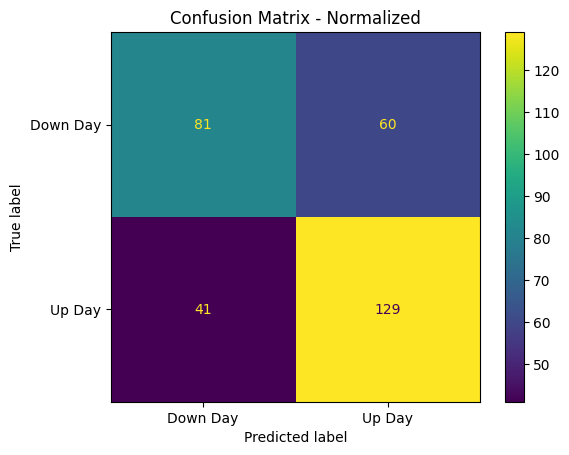

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = ConfusionMatrixDisplay(confusion_matrix= rf_matrix, display_labels=['Down Day', 'Up Day'])
disp.plot()

disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

## Model Evaluation: Feature Importance
With any model, you want to have an idea of what features are helping explain most of the model, as this can give you insight as to why you're getting the results you are. With Random Forest, we can identify some of our most important features or, in other words, the features that help explain most of the model. In some cases, some of our features might not be very important, or in other words, when compared to additional features, don't explain much of the model.


### Calculating the Feature Importance
Like all the previous steps, SkLearn makes this process very easy. Take your `rand_frst_clf` and call the `feature_importances_` property. This will return all of our features and their importance measurement. Store the values in a `Pandas.Series` object and sore the values.

Feature importance can be calculated two ways in Random Forest:

1. Gini-Based Importance
2. Accuracy-Based Importance


With `sklearn` they use the Gini-Importance metric for the Random Forest Algorithm.

We can see in our model, that the most important feature is `k_percent` and our least important feature is `On Balance Volume`.

In [79]:
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

k_percent               0.199737
r_percent               0.183953
RSI                     0.181406
MACD                    0.156099
Price_Rate_Of_Change    0.153989
On Balance Volume       0.124815
dtype: float64

## Model Evaluation: Feature Importance Graphing
 What I do in the chart below is chart the cumulative importance, in other words, how much does each feature add to the total. That way, we can see how much each feature is contributing to the overall importance. Another standard graph that is used is a bar chart.

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

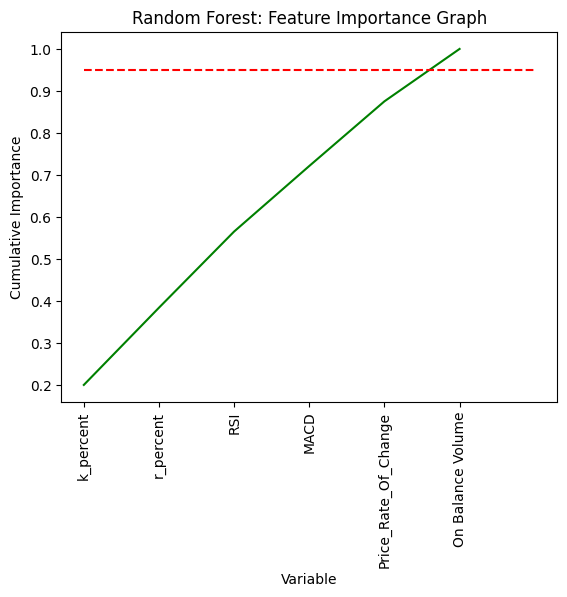

In [80]:
# store the values in a list to plot.
x_values = list(range(len(rand_frst_clf.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp.values)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

## Model Evaluation: ROC Curve
The Receiver Operating Characteristic is a graphical method to evaluate the performance of a binary classifier. A curve is drawn by plotting True Positive Rate (sensitivity) against False Positive Rate (1 - specificity) at various threshold values. ROC curve shows the trade-off between sensitivity and specificity. When the curve comes closer to the left-hand border and the top border of the ROC space, it indicates that the test is accurate. The closer the curve is to the top and left-hand border, the more accurate the test is. If the curve is close to the 45 degrees diagonal of the ROC space, it means that the test is not accurate. ROC curves can be used to select the optimal model and discard the suboptimal ones.

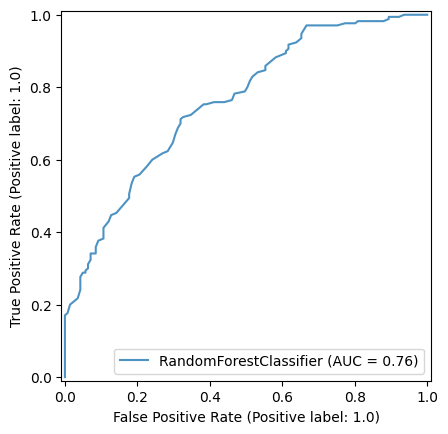

In [81]:
# Create an ROC Curve plot.
RocCurveDisplay.from_estimator(rand_frst_clf, X_test, y_test, alpha=0.8)
plt.show()

## Model Evaluation: Out-Of-Bag Error Score
The oob_score uses a sample of "left-over" data that wasn't necessarily used during the model's analysis, and the validation set is a sample of data you decided to subset. In this way, the OOB sample is a little more random than the validation set. Therefore, the OOB sample (on which the oob_score is measured) may be "harder" that the validation set. The oob_score may, on average, have a "less good" accuracy score as a consequence.

For example, Jeremy and Terence use only the last 2 weeks of grocery store data as a validation set. The OOB sample may have unused data from across all four years of sales data. The oob_score's sample is much harder because it's more randomized and has more variance.

If the oob_score never improves, but the validation set score is always excellent. You need to re-think how to subset the validation set. In the case of Jeremy and Terence, they might decide to take a more random sample of data across all years rather than strictly the last 2 weeks of data.

In [82]:
print('Random Forest Out-Of-Bag Error Score: {}'.format(rand_frst_clf.oob_score_))

Random Forest Out-Of-Bag Error Score: 0.6995708154506438


## Model Improvement: Randomized Search
With Random Forest, we have to try different values to find what the optimal values should be for each of the parameters. Fortunately, for us, this can be done using the `RandomizedSearchCV` method provided by `sklearn`.

The idea behind this approach is to provide a wide range of possible values for each hyperparameter and then using cross-validation, to try different combinations of these parameters. With the highest result of these combinations being the one, we should use for our data set.

To use this method, we need to first import the `RandomizedSearchCV` object from the `sklearn.model_selection` module. From there, we need to define a range of values for each of the hyperparameters we wish to test. To do this appropriately, we need to make sure we understand what each argument means in the model, so let's walk through them:

1. n_estimators - The number of trees in the forest.
2. max_features - The number of features to consider when looking for the best split.
3. max_depth - The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
4. min_samples_split - The minimum number of samples required to split an internal node.
5. min_samples_leaf - The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
6. bootstrap - Whether bootstrap samples are used when building trees. If False, the whole dataset is used to construct each tree.

In [83]:
# Number of trees in random forest
# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['sqrt', None, 'log2']

# Maximum number of levels in tree
# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


## Model Improvement: Running Randomized Search
Now that we've created a range of values for some of our hyperparameters, we can put them to the test. The first thing we need to do is create a new instance of our `RandomForestClassifier` model and pass it through to our `RandomizedSearchCV` object. When we use the `RandomizedSearchCV`, we need to specify a few additional arguments. 

The estimator is the model we wish to use; in this case, it's just our `RandomForestClassifier`. The `param_distribution` will get our `random_grid` dictionary. `n_iter` is an important argument because it will specify the number of iterations we will do, so the higher it is, the more iterations we will do. `cv`, defines the cross-validation splitting strategy we will use, `random_state` is used for random uniform sampling. `verbose` controls the verbosity: the higher, the more messages. `n_jobs` number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. 

In [84]:
# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[CV] END bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=14, min_samples_split=2, n_estimators=600; total time=   1.4s
[CV] END bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=14, min_samples_split=2, n_estimators=600; total time=   1.6s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=14, min_samples_split=2, n_estimators=600; total time=   1.5s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=40, n_estimators=1200; total time=   3.3s
[CV] END bootstrap=True, max

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', None, 'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
                   random_state=42, verbose=2)

In [85]:
# With the new Random Classifier trained we can proceed to our regular steps, prediction.
rf_random.predict(X_test)


'''
    ACCURACY
'''
# Once the predictions have been made, then grab the accuracy score.
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)


'''
    CLASSIFICATION REPORT
'''
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)


Correct Prediction (%):  70.41800643086816


,precision,recall,f1-score,support
Down Day,0.663934,0.574468,0.615970,141.000000
Up Day,0.682540,0.758824,0.718663,170.000000
accuracy,0.675241,0.675241,0.675241,0.675241
macro avg,0.673237,0.666646,0.667316,311.000000
weighted avg,0.674105,0.675241,0.672104,311.000000


k_percent               0.199737
r_percent               0.183953
RSI                     0.181406
MACD                    0.156099
Price_Rate_Of_Change    0.153989
On Balance Volume       0.124815
dtype: float64

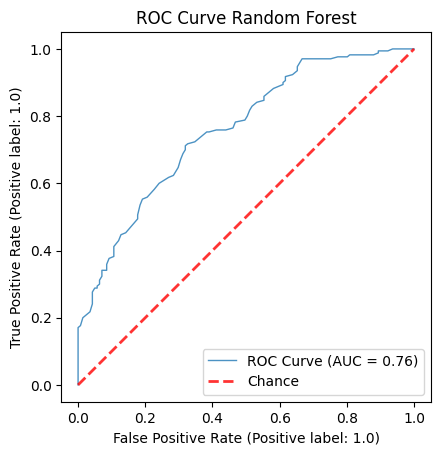

In [86]:
'''
    ROC CURVE
'''

fig, ax = plt.subplots()

# Create an ROC Curve plot using the updated method
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf, X_test, y_test, alpha=0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()
